## BCS2120 Introduction to AI Week 3 Lab: Building a Neural Network with AutoGrad Engine for Digit Recognition

This week, you'll build your first neural network to recognize handwritten digits. You'll also create a simple tool called an AutoGrad engine to help train your neural network. The lab is divided into three parts:

### 1. Developing the Training Process
   - **Data Loader**: Start by setting up a data loader that prepares small batches of data for training the neural network. You'll use a Python iterator for this task.
   - **AutoGrad Engine**: Follow the step-by-step guide in the iPython notebook to create an AutoGrad engine. This tool will help manage the computations needed to train a multi-layer neural network.
   - **Training the Neural Network**: Build and train a basic two-layer neural network that can classify images of handwritten digits.
   - **Report**: Include your understanding and problem-solving experiences when implementing the training process.

### 2. Enhancing Network Performance
   - **Performance Optimization**: Conduct experiments to boost your neural network's ability to recognize digits. This could involve adjusting settings (hyperparameters) and tweaking the network's structure.
   - **Evaluation**: Check how well your improved network performs using the evaluation methods you learned in Week 2.
   - **Report**: Include a detailed analysis of your experiments and results in the report.

### 3. Testing Your Optimized Network (Optional)
   - **Kaggle Test**: Test your refined model on a new set of data that it hasn't seen before. After your network predicts the digit labels, upload your results to Kaggle to see how accurate your model is.


#### Submit your report (3-6 pages) on Canvas together with all the code implemented in this notebook.

In [988]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from random import shuffle, randint
from PIL import Image
import math
from abc import ABC, abstractmethod

## Part 1: Developing the Training Process

### Step 1: Load training data from file

The following code use `pandas` library to load the `train.csv` file that contains the MNIST handwritten digit data for training and validating the neural network.

In [989]:
# Read all MNIST training data from the file
mnist_data = pd.read_csv('train.csv')
# Extract the image data from the data
mnist_data_x = mnist_data.iloc[:, 1:].values.astype('float')
# Extract the labels from the data
mnist_data_y = mnist_data.iloc[:, 0].values

We can visualize a digit using `matplotlib` library and check the given label of the digit.

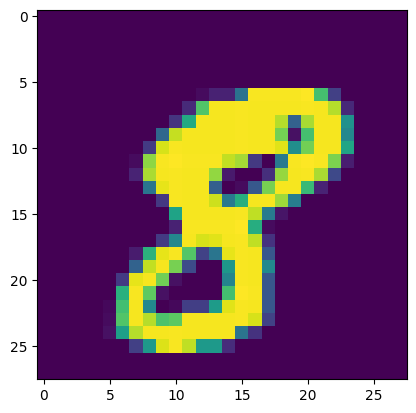

Label:  8


In [990]:
# Reshape one sample of data into a 2D image
mnist_image = mnist_data_x[10].reshape(28, 28, 1)
# Visulize the digit
plt.figure()
plt.imshow(mnist_image)
plt.show()
# Print label
print("Label: ", mnist_data_y[10])

### Task 1-1: Provide your own implementation

Here, you need to implement one line of code to print the dimension of the data `mnist_data_x`. If your implementation is correct, you will have the following output:

```
(42000, 784)
```

In [991]:
# Your code: print the dimension of mnist_data_x
print((mnist_data_x.shape))

(42000, 784)


### Task 1-2: Provide your own implementation

Here, you need to implement a python function `samples_per_class` to calculate the number of samples for each class in a specified subset of a dataset.

In [992]:
# Your code: implement the function
def samples_per_class(data_y, indices):
    """
    Calculate the number of samples for each class in a specified subset of a dataset.

    Parameters:
    data_y (numpy.ndarray): An array containing class labels for each sample in the dataset.
    indices (list): An array or list of indices specifying which samples to consider for the count.

    Return:
    list: A list of integers where each index corresponds to a class label (0 through 9), and the value at each index
          indicates the number of samples of that class present in the specified subset of `data_y`.
    """
    class_count = [0]*10
    for i in indices:
        class_count[data_y[i]] += 1 
    return class_count 

print(samples_per_class(mnist_data_y, [0,1,2,3,4]))

[2, 2, 0, 0, 1, 0, 0, 0, 0, 0]


### Test your own implementation

The following code will test your implementation by giving `indices` that includes the complete training data. If your implementation is correct, you will have the following output:

```
Number of samples per class in the full training data: [4132, 4684, 4177, 4351, 4072, 3795, 4137, 4401, 4063, 4188]
```

In [993]:
class_sample_num = samples_per_class(mnist_data_y, [idx for idx in range(len(mnist_data_y))])
print("Number of samples per class in the full training data:", class_sample_num)

Number of samples per class in the full training data: [4132, 4684, 4177, 4351, 4072, 3795, 4137, 4401, 4063, 4188]


### Step 2: Develop a data loader for mini-batch training

In this step, you will develop a data loader to load training and validate data. 

### Split the full data into train and validation sets

First, we give the `train_validate_split` function to split the indices of a dataset into training and validation sets based on the specified ratio for each class to maintain class distribution balance across both sets. This function will call the `samples_per_class` function defined by you to iterativly divide the data.

In [994]:
def train_validate_split(data_y, val_ratio=0.2):
    """
    Splits a dataset into training and validation sets based on the specified ratio
    for each class to maintain class distribution balance across both sets.

    The function ensures that each class is represented in the validation set
    proportionally to the specified validation ratio. This stratified approach helps in
    maintaining a consistent class distribution between the training and validation datasets.

    Parameters:
    data_y (numpy.ndarray): An array or list containing class labels for each sample in the dataset.
    val_ratio (float, optional): The proportion of the dataset to include in the validation split. This value should be
                                 a float between 0 and 1 indicating the percentage of data to be used as validation.
                                 Defaults to 0.2 (20% of the data).

    Returns:
    tuple of lists: A tuple containing two lists:
                     - train_indices (list): Indices of the samples designated for the training set.
                     - val_indices (list): Indices of the samples designated for the validation set.
    """
    sample_num = len(data_y)
    overall_indices = [num for num in range(sample_num)]
    overall_class_num = samples_per_class(data_y, overall_indices)
    val_class_num = [int(num*val_ratio) for num in overall_class_num]
    tmp_val_class_num = [0 for num in range(10)]
    shuffle(overall_indices)
    train_indices = []
    val_indices = []
    for idx in overall_indices:
        tmp_label = data_y[idx]
        if tmp_val_class_num[tmp_label] < val_class_num[tmp_label]:
            val_indices.append(idx)
            tmp_val_class_num[tmp_label] += 1
        else:
            train_indices.append(idx)
    return train_indices, val_indices

We can randomly divide our existing data into 80% training and 20% validation using the `train_validate_split` function. The divided training and validation dataset will have similar class distribution.

In [995]:
train_indices, val_indices = train_validate_split(mnist_data_y, val_ratio=0.2)
print("Training set sample number:", len(train_indices), "Validation set sample number:", len(val_indices))
print("Training set class distribution:", samples_per_class(mnist_data_y, train_indices))
print("Validation set class distribution:", samples_per_class(mnist_data_y, val_indices))

Training set sample number: 33604 Validation set sample number: 8396
Training set class distribution: [3306, 3748, 3342, 3481, 3258, 3036, 3310, 3521, 3251, 3351]
Validation set class distribution: [826, 936, 835, 870, 814, 759, 827, 880, 812, 837]


### Basics on Python Iterator

Before implementing the data loader for the MNIST dataset, you need to learn the basic concepts of Python Iterator. Here, we give a simple implementation of the Python native `range` iterator.

The Python iterator class needs to define 3 "dunder" methods:

1. **\_\_init__**: Initialization function of the class. This function will be called when initializing a new instance of the class.
2. **\_\_iter__**: Iterator function always return the iterator object. This function will be called when an iterator is required.
3. **\_\_next__**: Next function gets the next item in an iteration. This function will be called iteratively during an iteration.

In [996]:
class CustomRange:
    """
    A basic implementation of the range function which generates an iterator for a sequence of numbers.
    This custom range generates numbers from 0 up to a specified length.
    """

    def __init__(self, length):
        """
        Initialize the CustomRange instance.
        
        Args:
            length (int): The number of integers to generate, starting from 0 up to length-1.
        """
        self.length = length  # Maximum number to generate, starting from 0
        self.current = 0       # Current position in the sequence, starts at 0

    def __iter__(self):
        """
        Reset the iterator to its initial state and return itself.

        Returns:
            self (CustomRange): The iterator object.
        """
        self.current = 0  # Reset the current position to start iteration from the beginning
        return self

    def __next__(self):
        """
        Generate the next number in the sequence.
        
        Returns:
            int: The next number in the range.
        
        Raises:
            StopIteration: If the current position is equal to or exceeds the length.
        """
        if self.current < self.length:
            current_value = self.current  # Store the current value to return
            self.current += 1             # Increment the position by 1
            return current_value
        else:
            raise StopIteration  # Stop iteration if the current position reaches or exceeds the length

Let's try our own `range` iterator class. **What will happen if we don't reset `self.current` in `__iter__`?**

In [997]:
range_iterator = CustomRange(5)
for i in range_iterator:
    print(i)
    if i == 2:
        break
for i in range_iterator:
    print(i)

0
1
2
0
1
2
3
4


### Task 1-3: Provide your own implementation

Here, you will create your own implementation of a `DataLoader` class to iteratively load the MNIST dataset in mini-batches. The `DataLoader` will be used during both training and validation. Please follow the requirements below to ensure your implementation meets all specifications.

#### Key Requirements:

1. **The `DataLoader` should be an iterator class.**
   - The `DataLoader` class will be used as an iterator in `for`-loops during training and testing.
   - To make this work, you must implement the `__iter__()` and `__next__()` methods within the class.
   
2. **The `DataLoader` should only load a subset of the dataset.**
   - Your `DataLoader` will handle only a specific subset of the MNIST dataset, which is defined by the `sample_indices` list.
   - You will use the `train_indices` and `val_indices` lists (generated earlier) to create two separate `DataLoader` instances: one for the training set and one for the validation set.

3. **The `DataLoader` should load mini-batches of data and labels in each iteration.**
   - The `__next__()` method should load and return a mini-batch of data and labels in each iteration.
   - The batch size is specified by the `batch_size` parameter.
   - In each iteration, the method should return two NumPy arrays:
     1. A mini-batch of data with shape `(batch_size, 784)`.
     2. A mini-batch of labels with shape `(batch_size,)`.

4. **The iteration should cover all data samples in the subset.**
   - The `DataLoader` must iterate through all the samples in the specified dataset subset.
   - The iteration ends when all the samples have been returned.
   - Be mindful of the corner case where the remaining data samples are fewer than the batch size. In this scenario, return a mini-batch with a size smaller than `batch_size` for the final iteration.

5. **Support random shuffling for training.**
   - The `DataLoader` should support random shuffling of the dataset during training to enhance the training process.
   - Implement the shuffling within the `__iter__()` method, so that the samples are shuffled before each iteration.
   - After shuffling, the `__next__()` method should return the data in a different order for each training epoch.

#### Tips:
- Think carefully about how you’ll handle edge cases, such as when the number of remaining data samples is less than the batch size.
- Ensure your implementation is flexible and can support both shuffled and unshuffled iterations based on a parameter (for example, `shuffle=True/False`).

In [998]:
'''
Example Usage:

# Assume X and Y are your MNIST dataset loaded into numpy arrays
# X.shape -> (42000, 784), Y.shape -> (42000,)

# Assume train_indices represents the sample indices for training

# Create the DataLoader
data_loader = DataLoader(X, Y, batch_size=128, train_indices, shuffle=True)

# Use the DataLoader in a loop
for batch_x, batch_y in data_loader:
    print(batch_x.shape, batch_y.shape)
    # Here you would process your batch, e.g., train a model
'''

class DataLoader:
    def __init__(self, X, Y, batch_size, sample_indices, shuffle=True):
        """
        Initializes the DataLoader with data and configuration.

        Args:
        X (numpy.ndarray): The image data array, shape (n_samples, 784).
        Y (numpy.ndarray): The labels array, shape (n_samples,).
        batch_size (int): The number of samples per batch.
        sample_indices (list): The sampled indices included in the dataset.
        shuffle (bool): Whether to shuffle the data before creating batches (default: True).
        """
        self.X = X  # The input data array (data)
        self.Y = Y  # The labels array (labels)
        if len(self.X) != len(self.Y):
            raise ValueError("X and Y must have the same size")
        self.batch_size = batch_size  # Size of each mini-batch
        self.shuffle = shuffle  # Whether to shuffle the data at the start of each epoch
        self.current_index = 0  # Tracks the current position in the data for batching
        
        # If sample_indices are provided, use them to filter the data subset; 
        # otherwise, use the entire dataset by default
        if sample_indices:
            self.indices = sample_indices
        else:
            self.indices = np.arange(X.shape[0])  # Use all indices if no subset is specified

    # Your code: implement the function
    def __iter__(self):
        """
        Resets the iterator and shuffles the data if needed.
        
        This method is called at the beginning of a new iteration (e.g., in a for-loop).
        """
        # Shuffle the indices if needed
        if self.shuffle:
            np.random.shuffle(self.indices)
            
        # Load relevant data
        data = [self.X[index] for index in self.indices]
        labels = [self.Y[index] for index in self.indices]
        
        # Compute batches
        self.data_batch = []
        size = self.batch_size
        x_batch = []
        y_batch = []

        for x, y in zip(data, labels):
            x_batch.append(x)
            y_batch.append(y)
            
            size -= 1
            if size <= 0:
                self.data_batch.append([np.array(x_batch), np.array(y_batch)])
                x_batch, y_batch, size = [], [], self.batch_size
        
        # End conditions
        if len(x_batch) > 0:
            self.data_batch.append([np.array(x_batch), np.array(y_batch)])
        
        self.current = 0    
        self.length = len(self.data_batch)
        return self
        

    # Your code: implement the function
    def __next__(self):
        """
        Returns the next batch of data and labels.

        This method is called repeatedly by the iterator to get the next mini-batch.
        
        Raises:
        StopIteration: If there are no more data samples left to return.
        """
        
        if self.current < self.length:
            batch = self.data_batch[self.current]
            self.current += 1
            return batch
        else:
            raise StopIteration

### Test your own implementation

The following code will test the DataLoader iterator class you just implemented. The code creates a `DataLoader` object that will load the first 7 samples from the dataset with a batch size equal to 3. Since the number of samples will not be fully divided by the batch size, the last mini-batch will have a batch size smaller than 3.

First, we create a `DataLoader` object that doesn't do shuffling. Then, we use a for-loop to iterate the dataset and plot each mini-batch and the labels in the iteration.

Lables for mini-batch: [1 0 1]


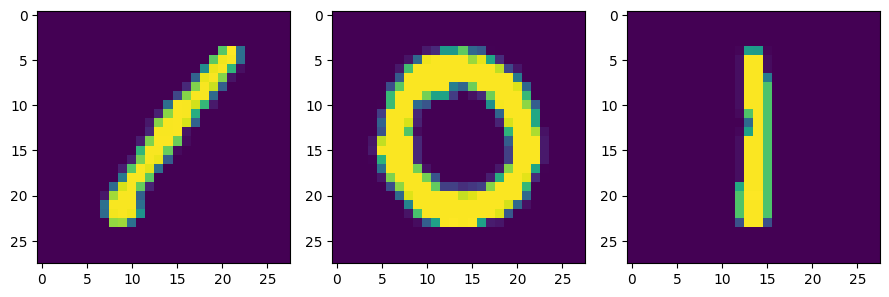

Lables for mini-batch: [4 0 0]


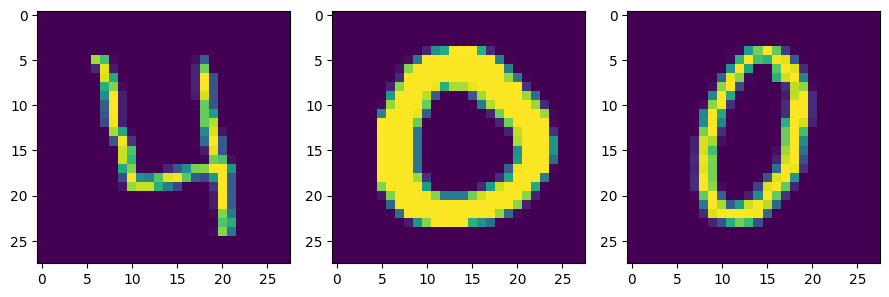

Lables for mini-batch: [7]


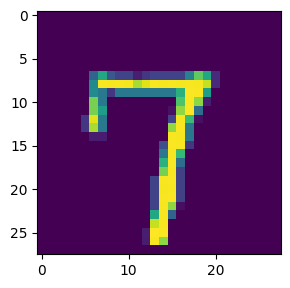

In [999]:
test_indices = [i for i in range(7)]
batch_size = 3
test_dataloader = DataLoader(mnist_data_x, mnist_data_y, batch_size, test_indices, shuffle=False)

for batch_x, batch_y in test_dataloader:
    print("Lables for mini-batch:", batch_y)
    return_batch_size = batch_x.shape[0]
    # Create a row of x subplots
    fig, axes = plt.subplots(1, return_batch_size, figsize=(return_batch_size*3, 3))  # Adjust figure size accordingly
    # If x is 1, axes is not a list, so we need to convert it to a list
    if return_batch_size == 1:
        axes = [axes]
    # Loop over the images and axes and plot each image
    for i in range(return_batch_size):
        axes[i].imshow(batch_x[i].reshape(28, 28, 1))
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

Since the `DataLoader` object doesn't do shuffling, the iterator will perform the same sequence iteration if we run a for-loop again on the same object.

Lables for mini-batch: [1 0 1]


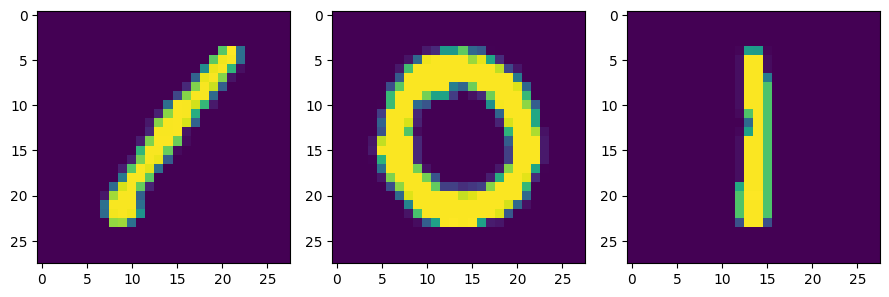

Lables for mini-batch: [4 0 0]


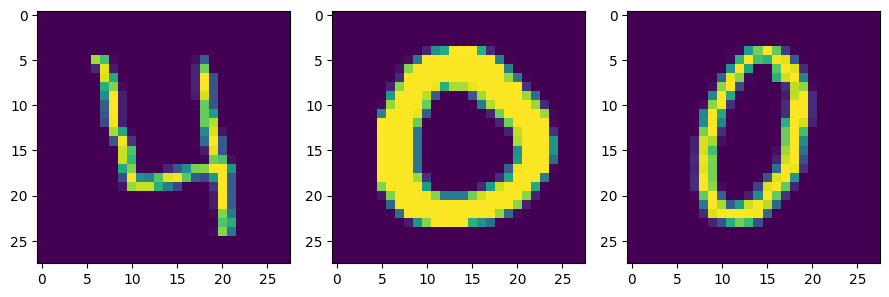

Lables for mini-batch: [7]


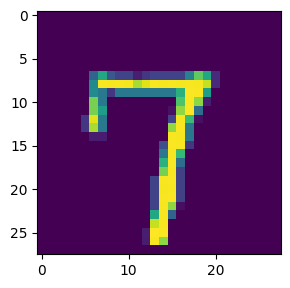

In [1000]:
for batch_x, batch_y in test_dataloader:
    print("Lables for mini-batch:", batch_y)
    return_batch_size = batch_x.shape[0]
    # Create a row of x subplots
    fig, axes = plt.subplots(1, return_batch_size, figsize=(return_batch_size*3, 3))  # Adjust figure size accordingly
    # If x is 1, axes is not a list, so we need to convert it to a list
    if return_batch_size == 1:
        axes = [axes]
    # Loop over the images and axes and plot each image
    for i in range(return_batch_size):
        axes[i].imshow(batch_x[i].reshape(28, 28, 1))
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

Next, we create a `DataLoader` object that will do shuffling at the start of iteration. You will observe the sequence of data iteration changes (here you will have different sequence everytime).

Lables for mini-batch: [1 4 0]


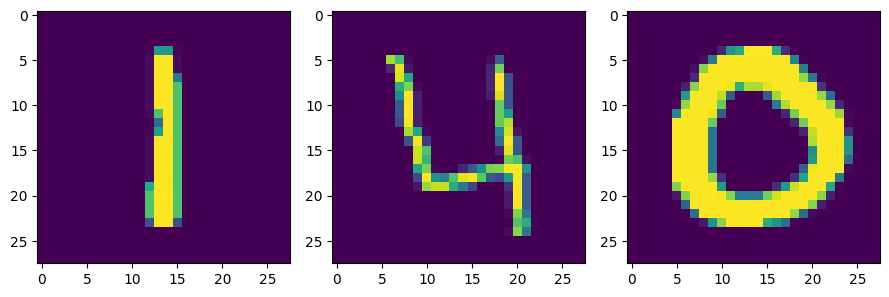

Lables for mini-batch: [0 1 7]


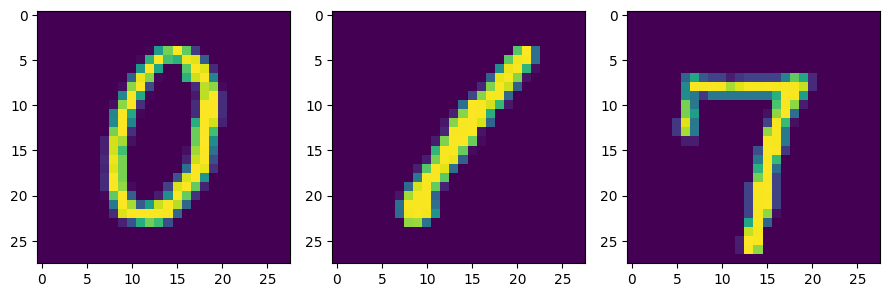

Lables for mini-batch: [0]


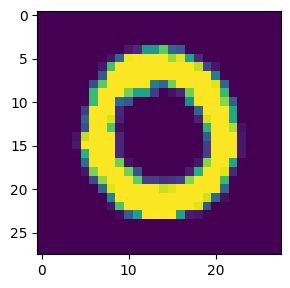

In [1001]:
rand_test_dataloader = DataLoader(mnist_data_x, mnist_data_y, batch_size, test_indices, shuffle=True)

for batch_x, batch_y in rand_test_dataloader:
    print("Lables for mini-batch:", batch_y)
    return_batch_size = batch_x.shape[0]
    # Create a row of x subplots
    fig, axes = plt.subplots(1, return_batch_size, figsize=(return_batch_size*3, 3))  # Adjust figure size accordingly
    # If x is 1, axes is not a list, so we need to convert it to a list
    if return_batch_size == 1:
        axes = [axes]
    # Loop over the images and axes and plot each image
    for i in range(return_batch_size):
        axes[i].imshow(batch_x[i].reshape(28, 28, 1))
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

### Step 3: Building the Simple AutoGrad Engine

In this step, we will build an AutoGrad engine that can automatically compute gradients using a computational graph. This engine, unlike the one discussed in Monday's lecture, will support vector data represented as Numpy arrays.

#### Defining the `Tensor` Data Type

The `Tensor` data type is foundational to our AutoGrad engine. It expands upon a basic vector, represented by a Numpy array, by incorporating additional components for gradient computation and graph tracking. Here are the 5 key components of a `Tensor` object:

1. **`data`**: This is the forward vector data, which is stored as a Numpy array.
2. **`grad`**: This component stores the gradient computed through backpropagation.
3. **`prev`**: This is a list of `Tensor` objects that contribute to the forward computation of this tensor, representing the graph's structure.
4. **`op`**: It represents the operation performed during the forward computation.
5. **`backward` function**: Perform depth-first search to compute the gradients of each node in the graph (See more details in the Lecture slides).

In [1002]:
class Tensor:
    """
    Represents a tensor object that is used in automatic differentiation.

    This class is designed to store data and associated operations for forward
    and backward passes in a computational graph. It supports operations on 
    vectors using Numpy arrays.

    Attributes:
        track_gradients (bool): Class level flag to track or not track gradients.
    """

    track_gradients = True  # Class variable to track or not track gradients

    def __init__(self, data, children=[], op=None):
        """
        Initializes a Tensor object.

        Args:
            data (np.array): The forward vector data stored as a Numpy array.
            children (list, optional): List of tensors that are predecessors in the 
                                       computational graph.
            op (Operation, optional): The operation that produced this tensor, used 
                                      during the backward pass.
        """
        self.data = data  # Holds the forward vector data as a Numpy array
        self.grad = 0  # Initializes the gradient to zero
        self.prev = children  # List of previous Tensor objects in the graph
        self.op = op  # Operation that produced this Tensor

    def backward(self, grad=None):
        """
        Performs the backward pass to compute gradients of the tensor with respect to
        some scalar value.

        Args:
            grad (np.array, optional): External gradient passed to this tensor. If None,
                                       gradients are initialized to match the shape of
                                       the tensor's data and set to ones.
        """
        if grad is None:
            self.grad = np.ones_like(self.data)  # Set gradient to one for scalar outputs
        else:
            self.grad = grad  # Use the externally provided gradient

        nodes = [self]  # Start with the current node
        while nodes:
            current_node = nodes.pop()  # Process one node at a time
            if current_node.op:
                current_node.op.backward(current_node)  # Call backward method of the operation
            for input_node in current_node.prev:
                nodes.append(input_node)  # Add input nodes to the list to process them

#### Define different `op` operations using `TensorFunction`

The `TensorFunction` defines in detail the forward computation and backward computation for an operation. The `TensorFunction` given here is an abstract class. It gives an template for implementing different operation classes.

In [1003]:
class TensorFunction(ABC):
    """
    Abstract base class for defining tensor operations.
    
    This class is designed to be inherited by specific tensor operation classes, which must
    implement the forward and backward methods. These methods define how the operation is
    performed in the forward pass and how gradients are handled in the backward pass.
    """

    @abstractmethod
    def forward(self, *args):
        """
        Computes the forward pass of the operation.

        This method must be implemented by all subclasses to perform the specific operation.
        It takes variable number of tensor inputs and computes the result of the operation.

        Args:
            *args: A variable-length argument list of tensors compatible with the operation.

        Returns:
            The result of the tensor operation as part of the forward computation.
        """
        pass

    @abstractmethod
    def backward(self, *args):
        """
        Computes the backward pass of the operation.

        This method must be implemented by all subclasses to handle the propagation of gradients
        through this operation. It is called during the backward pass of the automatic differentiation.

        Args:
            *args: A variable-length argument list, typically including gradients along with the
                   tensors involved in the forward operation.
        """
        pass

    def __call__(self, *args):
        """
        Allows the object to be called like a function, using the defined forward method.

        This makes instances of subclasses callable, simplifying usage by abstracting the
        method call. When the instance is called, it automatically triggers the `forward` method.

        Args:
            *args: A variable-length argument list passed to the `forward` method.

        Returns:
            The result of the forward method.
        """
        return self.forward(*args)  # Delegate to the forward method

#### Define the `ADD` operation

Here, we give an example on how to define the `ADD` operation for the tensors. To do so, we need to first define the computation required for forward and backward functions.

Suppose we want to perform addition on two vectors $X$ and $Y$.

* **Forward**: $Z=X+Y$
* **Backward**: $\frac{\partial L}{\partial X}=\frac{\partial L}{\partial Z}$, $\frac{\partial L}{\partial Y}=\frac{\partial L}{\partial Z}$

In [1004]:
class Add(TensorFunction):
    """
    Implements the addition operation for tensors.

    This class inherits from `TensorFunction` and defines how tensors are added in the forward
    pass and how gradients are propagated back in the backward pass. It supports operations on 
    tensors that may or may not track gradients.
    """

    def forward(self, X, Y):
        """
        Performs the forward pass of the addition operation.

        Args:
            X (Tensor): The first operand tensor.
            Y (Tensor): The second operand tensor.

        Returns:
            Tensor: The result of adding X and Y, with appropriate graph connections if gradients
                    are being tracked.
        """
        if Tensor.track_gradients:
            # Create a new tensor that is the sum of X and Y, tracking the operation and parents in the graph.
            Z = Tensor(X.data + Y.data, children=[X, Y], op=self)
        else:
            # Create a new tensor that is the sum of X and Y without tracking the graph.
            Z = Tensor(X.data + Y.data)
        return Z

    def backward(self, dZ):
        """
        Performs the backward pass of the addition operation.

        This method propagates gradients from the result tensor to the operand tensors.

        Args:
            dZ (Tensor): The derivative of the output tensor with respect to some upstream gradient.
        """
        # Retrieve the tensors involved in the forward operation.
        X = dZ.prev[0]
        Y = dZ.prev[1]

        # Update gradients of X and Y by adding the gradient of the output tensor, respecting existing gradients.
        X.grad += dZ.grad
        Y.grad += dZ.grad

### Task 1-4: Provide your own implementation

Here, you will create your own implementations for the `MatMul` operation on matrix multiplication and the `ReLU` operation on the non-linear activation function. Same as `ADD`, we need to first define the computation required for forward and backward functions.

#### `MatMul` operation

Suppose we want to perform matrix multiplication on two matrices $X$ and $Y$.

* **Forward**: $Z=X\cdot Y$
* **Backward**: $\frac{\partial L}{\partial X}=\frac{\partial L}{\partial Z}\cdot Y^T$, $\frac{\partial L}{\partial Y}=X^T\cdot \frac{\partial L}{\partial Z}$

#### `ReLU` operation

Support we want to apply the ReLU activation function on a vector $X$.

* **Forward**: $Z=max(X, 0)$
* **Backward**: For $x_i \in X,z_i \in Z$, $\frac{\partial L}{\partial x_i}=\frac{\partial L}{\partial z_i}$ if $x_i > 0$. $\frac{\partial L}{\partial x_i}=0$ if $x_i <= 0$, .

In [1005]:
class MatMul(TensorFunction):
    # Your code: implement the function
    def forward(self, X, Y):
        if Tensor.track_gradients:
            Z = Tensor(X.data @ Y.data, children=[X, Y], op=self)
        else:
            Z = Tensor(X.data @ Y.data)
        # print(np.max(Z.data))
        return Z
    
    # Your code: implement the function
    def backward(self, dZ):
        X = dZ.prev[0]
        Y = dZ.prev[1]
        
        X.grad += dZ.grad @ Y.data.T
        Y.grad += X.data.T @ dZ.grad

class ReLU(TensorFunction):
    # Your code: implement the function
    def forward(self, X):
        
        array = np.maximum(X.data, 0)
        if Tensor.track_gradients:
            Z = Tensor(np.array(array), children=[X], op=self)
        else:
            Z = Tensor(np.array(array))
        return Z
    
    # Your code: implement the function
    def backward(self, dZ):
        X = dZ.prev[0]
        
        X.grad += np.array(np.where(X.data > 0, dZ.grad, 0))

### Test your own implementation

The following code will test your implementations for the operations. First we test the `ADD` and `MatMul` operations. If your implementation is correct, the code will print these outputs for forward and backward results:

```
Forward computation result: [[46 54]
 [27 18]]
Gradient w.r.t. A: [[15 15]
 [ 7  7]]
Gradient w.r.t. B: [[15 15]
 [ 7  7]]
Gradient w.r.t. C: [[ 5 10]
 [ 5 10]]
```

In [1006]:
A = Tensor(np.array([[1, 2], [3, 4]]))
B = Tensor(np.array([[2, 0], [1, 2]]))
C = Tensor(np.array([[6, 7], [9, 0]]))

add_op = Add()
matmul_op = MatMul()

D = add_op(A, B)
E = matmul_op(C, D)

E.backward()

print("Forward computation result:", E.data)
print("Gradient w.r.t. A:", A.grad)
print("Gradient w.r.t. B:", B.grad)
print("Gradient w.r.t. C:", C.grad)

Forward computation result: [[46 54]
 [27 18]]
Gradient w.r.t. A: [[15 15]
 [ 7  7]]
Gradient w.r.t. B: [[15 15]
 [ 7  7]]
Gradient w.r.t. C: [[ 5 10]
 [ 5 10]]


Next, we test the `ReLU` operation. If your implementation is correct, the code will print these outputs for forward and backward results:

```
Forward computation result: [0.  0.5 0.  1.5]
Gradient w.r.t X: [0. 1. 0. 1.]
```

In [1007]:
X = Tensor(np.array([-1.0, 0.5, 0.0, 1.5]))
relu_op = ReLU()

Z = relu_op(X)

Z.backward()

print("Forward computation result:", Z.data)
print("Gradient w.r.t X:", X.grad)

Forward computation result: [0.  0.5 0.  1.5]
Gradient w.r.t X: [0. 1. 0. 1.]


### Step 4: Defining a two-layer fully-connected neural network

We have everything to build our neural network. We start by building a single fully connected layer of the network.

### Task 1-5: Provide your own implementation

Here, you will implement the `forward` function of the `LinearLayer` class representing the forward computation of a fully connected layer. Based on the forward operations, the AutoGrad engine you just defined will automatically perform the backward computation. First, we define the forward computation of a fully connected layer:

Suppose we have input $X$ to the layer, the output $Z=X\cdot Weight+Bias$. $Weight$ and $Bias$ are parameters of the layer that will be trained later. In the `__init__` function all the parameters are randomly initialized using the same way as in `PyTorch`. The parameters are also tracked in the `param` variable of the class.

If the layer supports ReLU activation function, then the output $Z=ReLU(X\cdot Weight+Bias)$.

In [1008]:
class LinearLayer:
    """
    Represents a linear layer in a neural network with optional activation.

    This layer computes a linear transformation on the input data followed by an activation function. 
    It initializes weights and biases uniformly within a range determined by the input dimension size, 
    to help in stabilizing the learning process.
    """

    def __init__(self, input_dim, output_dim, activation='relu'):
        """
        Initializes the LinearLayer with specified input and output dimensions and activation.

        Args:
            input_dim (int): Dimensionality of the input features.
            output_dim (int): Dimensionality of the output features.
            activation (str, optional): Type of activation to use; defaults to 'relu'.
        """
        # Initialize weights and biases within a range that depends on the input dimension.
        # This is a common heuristic used to help in the convergence of training.
        limit = 1 / np.sqrt(input_dim)
        self.weights = Tensor(np.random.uniform(-limit, limit, (input_dim, output_dim)))
        self.bias = Tensor(np.random.uniform(-limit, limit, (1, output_dim)))
        self.param = [self.weights, self.bias]

        # Initializing operations for matrix multiplication and addition.
        self.matmul = MatMul()
        self.add = Add()

        # Set the activation function; default is ReLU.
        self.activation = ReLU() if activation == 'relu' else None

    # Your code: implement the function
    def forward(self, x):
        """
        Computes the forward pass of the linear layer.

        Args:
            x (Tensor): The input tensor.

        Returns:
            Tensor: The output tensor after applying the linear transformation and activation function.
        """         
        A =  self.matmul(x, self.weights)
        Z = self.add(A, self.bias)
        
        if self.activation:
            return self.activation(Z)
        else:
            return Z
        

### Test your own implementation

The following code will test your implementations for the layer using a random input tensor with dimension $(batch\_size=8, input\_dim=5)$. The output dimension of the layer will be $3$. If your implementation is correct, you will get the gradients for weights and biases.

In [1009]:
# Create a random input tensor
input_data = Tensor(np.random.randn(8, 5))
# Create a layer object
layer = LinearLayer(5, 3)
# Perform forward propagation
output = layer.forward(input_data)
# Perform backpropagation
output.backward()

print("Outputs of the Layer:", output.data)
print("Gradients w.r.t Weights:", layer.weights.grad)
print("Gradients w.r.t Biases:", layer.bias.grad)

Outputs of the Layer: [[0.         0.50036113 0.08826767]
 [0.         0.14654867 0.        ]
 [0.60104482 0.3348924  0.44786043]
 [0.88714295 0.         0.08063096]
 [0.04299661 0.37647665 0.48890136]
 [0.         0.55760136 0.        ]
 [0.38407511 0.         0.55474385]
 [0.         0.25904877 0.12171561]]
Gradients w.r.t Weights: [[ 1.42323705  0.42311223  1.33131134]
 [ 1.36504147  1.21917779  1.6663496 ]
 [ 2.50544911 -0.09536861  2.65381513]
 [ 0.11476288  0.67578449 -0.20162435]
 [ 2.2663332  -1.26702495  0.88071227]]
Gradients w.r.t Biases: [[0. 1. 1.]
 [0. 1. 0.]
 [1. 1. 1.]
 [1. 0. 1.]
 [1. 1. 1.]
 [0. 1. 0.]
 [1. 0. 1.]
 [0. 1. 1.]]


### Task 1-6: Provide your own implementation

Here, you will develop an `MLP` class that represents a two-layer fully-connected neural network. Please ensure your implementation adheres to the key requirements outlined below to meet all the specified criteria.

### Key Requirements

1. **Layer Structure**
    - **`hidden_layer`**: This layer takes the network's input and outputs a tensor with dimensions specified by `hidden_dim`. It also applies a ReLU activation function to introduce non-linearity.
    - **`output_layer`**: Receives inputs from the `hidden_layer` and outputs a tensor with dimensions specified by `output_dim`. This layer does not utilize any activation function.

2. **Parameter Tracking**
    - Implement a `param` class variable that compiles a list of parameters from all layers. This list should include both weights and biases.
    - The `param` list is crucial as it will be utilized by an optimizer to update the parameters during the training process.

Please follow the above specifications closely to ensure your implementation functions correctly and integrates seamlessly with additional components like optimizers and loss functions in subsequent parts of the course.

In [1010]:
class MLP:
    """
    Represents a simple Multi-Layer Perceptron (MLP) with two fully-connected layers.

    This class defines a neural network with one hidden layer and one output layer,
    both fully connected. The hidden layer includes an activation function (ReLU),
    while the output layer doesn't have an activation, making it suitable for classification.

    Attributes:
        hidden_layer (LinearLayer): The hidden layer of the MLP.
        output_layer (LinearLayer): The output layer of the MLP.
        param (list): Aggregated list of parameters from both layers for training purposes.
    """

    # Your code: implement the function
    def __init__(self, input_dim, hidden_dim, output_dim):
        """
        Initializes the MLP with specified dimensions for each layer.

        Args:
            input_dim (int): The size of the input feature vector.
            hidden_dim (int): The number of neurons in the hidden layer.
            output_dim (int): The number of neurons in the output layer.
        """
        self.hidden_layer = LinearLayer(input_dim, hidden_dim)
        self.output_layer = LinearLayer(hidden_dim, output_dim, activation="")
        self.param = np.array([self.hidden_layer.param, self.output_layer.param]).flatten()

    # Your code: implement the function
    def forward(self, x):
        """
        Computes the forward pass of the MLP.

        Args:
            x (Tensor): Input tensor to the neural network.

        Returns:
            Tensor: Output tensor after processing through both layers of the MLP.
        """
        hidden = self.hidden_layer.forward(x)  

        return self.output_layer.forward(hidden)  

### Test your own implementation

The following code will test your implementations for the network using a random input tensor with dimension $(batch\_size=8, input\_dim=5)$. The hidden dimension of the network will be $4$ and output dimension will be $3$. If your implementation is correct, you will get the gradients for weights and biases for all layers.

In [1011]:
# Create a random input tensor
input_data = Tensor(np.random.randn(8, 5))
# Create a Network object
network = MLP(5, 4, 3)
# Perform forward propagation
output = network.forward(input_data)
# Perform backpropagation
output.backward()

print("Outputs of the network:", output.data)
print("Gradients w.r.t Hidden Weights:", network.hidden_layer.weights.grad)
print("Gradients w.r.t Hidden Biases:", network.hidden_layer.bias.grad)

Outputs of the network: [[-0.39770535 -0.55300374  0.07344521]
 [-0.72250225 -0.66974663  0.22406167]
 [ 0.05617321 -0.17930146 -0.28025944]
 [-0.45759204 -0.49681073 -0.0521537 ]
 [-0.1356224  -0.30620147 -0.27039192]
 [-0.37916581 -0.36472985 -0.23397836]
 [-0.3752138  -0.53671388  0.02534026]
 [-0.21419966 -0.37539766 -0.22629696]]
Gradients w.r.t Hidden Weights: [[ 0.21582634 -0.30066305  0.00689259  0.52416556]
 [ 1.32293087  0.54957751 -0.40847024 -1.36698632]
 [ 0.95992863  0.15084036 -0.90364295 -1.92520563]
 [-0.02191037 -0.48632745 -0.06650252 -0.94872524]
 [ 0.12868699  0.25446253 -0.26827235 -0.89489102]]
Gradients w.r.t Hidden Biases: [[-0.36961705 -0.22353564  0.23898023  0.47078621]
 [-0.36961705 -0.22353564  0.          0.        ]
 [-0.36961705  0.          0.23898023  0.47078621]
 [-0.36961705 -0.22353564  0.          0.        ]
 [-0.36961705  0.          0.          0.47078621]
 [-0.36961705 -0.22353564  0.23898023  0.47078621]
 [ 0.         -0.22353564  0.         

### Step 5: Defining loss function, optimizer, and other components

In this step, we will define the remaining components required to train a neural network. More specifically, we will design 3 components for supporting the training and validation of neural networks:

1. **Loss Function**: We will define a CrossEntropy loss function for classification tasks.
2. **Optimizer**: We will define an SGD optimizer to update the parameters using gradients.
3. **no_grad**: We will implement a Python context manager that disables gradient computation during validation.

#### Define loss function `SoftmaxCrossEntropy`

We define the CrossEntropy loss function the same way as in PyTorch. The implementation is the same as how we define other operations of Tensors. You can learn more about this loss function in the [PyTorch documentation](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).

In [1012]:
class SoftmaxCrossEntropy(TensorFunction):
    """
    Implements the softmax activation followed by the cross-entropy loss function.

    This class provides a method to perform a stable calculation of the softmax activation 
    and compute the cross-entropy loss between the predicted probabilities and the actual labels.
    It is particularly useful for training classification models where the outputs are 
    probabilities that sum to one.
    """

    def forward(self, outputs, labels):
        """
        Computes the forward pass using softmax for predictions and cross-entropy for loss.

        Args:
            outputs (Tensor): The logits predicted by the model (before softmax).
            labels (Tensor): The true labels, one-hot encoded.

        Returns:
            Tensor: The mean cross-entropy loss as a tensor.
        """
        # Perform a stable softmax computation to avoid numerical overflow.
        exps = np.exp(outputs.data - np.max(outputs.data, axis=1, keepdims=True))
        self.softmax = exps / (np.sum(exps, axis=1, keepdims=True) + 1e-8)

        # Compute the cross-entropy loss.
        cross_entropy = -np.sum(labels.data * np.log(self.softmax + 1e-8), axis=1)
        mean_loss = np.mean(cross_entropy)

        # Wrap the mean loss in a Tensor, tracking the computation graph if necessary.
        if Tensor.track_gradients:
            loss = Tensor(mean_loss, children=[outputs, labels], op=self)
        else:
            loss = Tensor(mean_loss)
        return loss

    def backward(self, dL):
        """
        Backpropagates the error through the softmax and cross-entropy loss.

        Args:
            dL (Tensor): The gradient tensor of the loss with respect to the output of this operation.

        Modifies:
            outputs.grad (np.array): Updated gradient of the outputs as computed by the backward pass.
        """
        outputs = dL.prev[0]
        labels = dL.prev[1]
        batch_size = outputs.data.shape[0]
        # Compute the gradient of the loss with respect to the input.
        outputs.grad = (self.softmax - labels.data) / batch_size

### Task 1-7: Provide your own implementation

To use the loss function, we need to convert the ground truth label index into a one-hot vector. Here, you will implement a function to perform this conversion.

#### Label index to one-hot vector conversion

You will convert a label index (e.g. $3$) to a one-hot vector (e.g. $[0, 0, 1, 0, 0, 0, 0]$)

In [1013]:
# Your code: implement the function
def one_hot_encode(labels, num_classes=10):
    """
    Convert an array of numeric labels into a one-hot encoded matrix.

    Args:
        labels (np.array): Array of integer labels.
        num_classes (int, optional): Total number of classes.

    Returns:
        np.array: A matrix of one-hot encoded vectors where each row corresponds to a one-hot vector.
    """
    return [[1 if i == label else 0 for i in range(num_classes)] for label in labels]
    

### Test your own implementation

The following code will test you implementation of the `one_hot_encode` function. The code will use the function to convert labels and compute the loss. If your implementation is correct, the code will print these outputs for forward and backward results:

```
One hot labels: [[0. 1. 0.]
 [0. 0. 1.]]
Loss value: 1.8670299515161022
Gradient w.r.t logits: [[ 0.32950057 -0.37878352  0.04928294]
 [ 0.12121648  0.32950057 -0.4507176]]

```

In [1014]:
# Define network output for the loss function
logits = Tensor(np.array([[2.0, 1.0, 0.1], [1.0, 2.0, 0.1]]))  # logits for 2 examples and 3 classes
# Ground truth label index
labels = np.array([1, 2])
# Convert label index to one hot vector
one_hot_labels = one_hot_encode(labels, num_classes=3)
# Convert vector to a tensor
one_hot_labels_tensor = Tensor(one_hot_labels)
# Create loss object
loss_op = SoftmaxCrossEntropy()
# Apply loss function forward propagation
loss = loss_op(logits, one_hot_labels_tensor)
# Perform backward propagation
loss.backward()

print("One hot labels:", one_hot_labels)
print("Loss value:", loss.data)
print("Gradient w.r.t logits:", logits.grad)

One hot labels: [[0, 1, 0], [0, 0, 1]]
Loss value: 1.8670299515161022
Gradient w.r.t logits: [[ 0.32950057 -0.37878352  0.04928294]
 [ 0.12121648  0.32950057 -0.45071706]]


#### Define optimizer `SGDOptimizer`

We define a SGD optimizer to update the parameters after the gradients are computed by the backpropagation. The optimizer has a hyperparameter `lr` controls the learning rate of the update. The `step` function updates the weight after backpropagation. The `zero_grad` function reset all gradients in the network back to zero.

In [1015]:
class SGDOptimizer:
    """
    Implements the Stochastic Gradient Descent (SGD) optimization algorithm.

    This optimizer updates the parameters of a model by moving them in the direction of
    the negative gradient of the loss function, scaled by a learning rate. This approach
    is one of the most common methods used for training various types of neural networks.
    """

    def __init__(self, parameters, lr=0.01):
        """
        Initializes the SGDOptimizer with given parameters and learning rate.

        Args:
            parameters (list): List of parameters to optimize.
            lr (float, optional): Learning rate for the optimizer. Default is 0.01.
        """
        self.parameters = parameters  # Model parameters to be optimized
        self.lr = lr  # Learning rate for optimization

    def step(self):
        """
        Performs a single optimization step on parameters.

        This method iterates through all parameters and updates them based on their
        gradients and the learning rate. It adjusts for parameter dimensions as needed.
        """
        for param in self.parameters:
            # Check if the parameter and its gradient dimensions require summing (i.e. Bias)
            if param.data.shape[0] == 1 and param.grad.shape[0] > 1:
                # Apply the learning rate and update the parameter for broadcast compatibility
                param.data -= self.lr * np.sum(param.grad, axis=0, keepdims=True)
            else:
                # Standard parameter update
                param.data -= self.lr * param.grad  # Update parameter based on its gradient

    def zero_grad(self):
        """
        Resets all parameter gradients to zero.

        This method is typically called after each training step to prevent accumulation
        of gradients across multiple passes.
        """
        for param in self.parameters:
            param.grad = 0  # Reset the gradient for each parameter to zero


#### Define Python context manager `no_grad`

Since we don't need to train the network during validaton, we want to disable the backpropagation. We can do this by using the Python context manager `with`. Therefore, we need to define a class to define the context. To define a Python context manager class, we need to define two methods:

1. **`__enter__`**: Define the operations when entering the context. Here, we want to disable the `track_gradients` of all tensors.
2. **`__exit__`**: Define the operations when exiting the context. Here, we want to resume the `tract_gradients` of all tensors.

In [1016]:
class no_grad:
    def __enter__(self):
        # Save the current state (whether gradients are currently being tracked)
        self.prev_state = Tensor.track_gradients
        # Disable gradient tracking
        Tensor.track_gradients = False

    def __exit__(self, exc_type, exc_val, exc_tb):
        # Restore the original gradient tracking state
        Tensor.track_gradients = True

We can use the Python context manager using the `with` statement. Here, let's try to perform network layer forward and backward computation inside the `no_grad` context.

In [1017]:
# Example usage of no_grad
layer = LinearLayer(5, 3)
input_data = Tensor(np.random.randn(10, 5))

with no_grad():
    output = layer.forward(input_data)
    output.backward()
    print("Weight grad with no_grad:", layer.weights.grad)

Weight grad with no_grad: 0


### Step 6. Training our neural network

This is the last step of Part 1 of the lab. We will combine everything we implemented to train and validate our neural network. First, we will define our training set dataloader and validation set dataloader. We will use the `train_indices` and `val_indices` computed in Step 1 to perform the dataset splitting.

In [1018]:
batch_size = 64
# Define training set dataloader object
train_dataloader = DataLoader(mnist_data_x, mnist_data_y, batch_size, train_indices)
# Define validation set dataloader object
val_dataloader = DataLoader(mnist_data_x, mnist_data_y, batch_size, val_indices)

Next, we will define our neural network, optimizer, and loss function using the classes we implemented.

In [1019]:
# Define neural network
network = MLP(28*28, 128, 10)
# Define optimizer
optimizer = SGDOptimizer(network.param, lr=0.001)
# Define loss function
loss_func = SoftmaxCrossEntropy()

### Task 1-8: Provide your own implementation

In this task, you will develop a `validation_func` to assess the performance of your trained neural network on a validation dataset. This function will compute and return the prediction accuracy, making it essential for understanding the model's effectiveness.

### Validation Process

Follow these steps to implement the `validation_func`:

1. **Iterate through the Validation Data Loader:**
   - Use the `val_dataloader` to retrieve mini-batches of digit data and corresponding labels during each iteration.

2. **Identify Predictions:**
   - Determine the predicted class for each sample in the mini-batch by identifying the index with the maximum value in the output dimension of the network's response.

3. **Count Correct Predictions:**
   - Compare each predicted class with its corresponding true label. Record the total number of correct predictions made by the neural network.

4. **Calculate Validation Accuracy:**
   - Compute the accuracy of the model on the validation set by dividing the number of correct predictions by the total number of samples in the validation set.

5. **Return Performance Metrics:**
   - Return the calculated accuracy, along with the count of correct predictions and the overall number of samples in the validation dataset.

In [1027]:
# Your code: implement the function
def validation_func(network, val_dataloader):
    """
    Computes the validation accuracy of a neural network.

    This function iterates through a validation dataset using a dataloader,
    calculates the number of correct predictions the network makes, and computes
    the overall accuracy of the network on this validation set.

    Args:
        network: The neural network model to validate.
        val_dataloader: The dataloader that provides batches of validation data.

    Returns:
            - accuracy (float): The proportion of correct predictions.
            - correct_num (int): Total number of correct predictions.
            - total_num (int): Total number of samples in the validation set.
    """
    with no_grad():
        correct_num = 0
        total_num = 0
        for batch_x, batch_y in val_dataloader:
            total_num += batch_y.shape[0]
            output = network.forward(batch_x)
            output_label = np.array([np.argmax(outs) for outs in output.data])
            
            correct_num += sum([1 if label == y else 0 for label, y in zip(output_label, batch_y)])
        
        return float(correct_num/total_num), correct_num, total_num

### Test your own implementation

The following code will test your implementation of the `validation_func` function. The code tests an un-trained neural network. Therefore, the accuracy of the prediction will be at chance level.

In [1021]:
accuracy, correct_num, total_num = validation_func(network, val_dataloader)
print("Validation accuracy:", accuracy, "Number of correct prediction:", correct_num, "Number of validation samples:", total_num)

Validation accuracy: 0.11958075273939972 Number of correct prediction: 1004 Number of validation samples: 8396


### Task 1-9: Provide your own implementation

In this task, you are required to implement the `train_func` function, which is responsible for training the neural network. This function will orchestrate the training process, perform validations, and manage updates to the model parameters.

### Training Process

Follow these detailed steps to successfully implement the training process:

1. **Epoch Definition**:
   - An **epoch** represents one complete pass through the entire training dataset.
   - The total number of epochs for training the neural network is specified by the `epoch_num` hyperparameter.

2. **Batch Processing**:
   - Iterate through `train_dataloader` to process mini-batches of digit data and their corresponding labels.

3. **Data Transformation**:
   - Convert digit data into tensors.
   - Use the `one_hot_encode` function to convert labels into one-hot vectors and then transform these into tensors.

4. **Forward Propagation**:
   - Execute the forward propagation step to obtain predictions from the network.

5. **Loss Computation**:
   - Calculate the loss for the predictions using the `loss_func`.

6. **Backward Propagation**:
   - Perform backward computation starting from the computed loss to update model gradients.

7. **Parameter Update**:
   - Apply the `optimizer` to update the network parameters.
   - Reset all gradients to zero post-update.

8. **Validation**:
   - After each epoch, execute the `validation_func` to assess the performance of the trained model on the validation dataset.

9. **Tracking Validation Accuracy**:
   - Record the validation accuracy after each epoch into a list.
   - Return this list as the output of the `train_func` to track performance over time.

In [1022]:
# Your code: implement the function
def train_func(network, train_dataloader, val_dataloader, optimizer, loss_func, epoch_num):
    """
    Trains a neural network using the provided training and validation data loaders.

    This function orchestrates the training process over a specified number of epochs,
    updating model parameters with an optimizer, and evaluates the model performance
    on a validation dataset after each epoch. It records and returns the validation 
    accuracies for each epoch.

    Args:
        network: The neural network model to be trained.
        train_dataloader (iterable): DataLoader providing batches of training data.
        val_dataloader (iterable): DataLoader for providing batches of validation data.
        optimizer: The optimization algorithm (e.g., SGD) to update network weights.
        loss_func: The loss function to be used for training evaluation.
        epoch_num (int): The number of training epochs.

    Returns:
        np.array: An array of validation accuracies for each training epoch.
    """
    validation_acc = []
    for epoch in range(epoch_num):
        i = 0
        for x, y in train_dataloader:
            # (x-np.mean(x))/np.sqrt(np.std(x)**2)
            output = network.forward(Tensor(x))

            labels = Tensor(one_hot_encode(y, num_classes=10))
            loss = loss_func.forward(output, labels)
            if np.isnan(loss.data):
                # print(i)
                pass
            i += 1
            loss_func.backward(loss)
            output.backward(output.grad)
            
            optimizer.step()
            optimizer.zero_grad()
            
        with no_grad():
            accuracy, correct_num, total_num = validation_func(network, val_dataloader)
            validation_acc.append(accuracy)

    return validation_acc

### Test your own implementation

The following code will test your implementation of the `train_func` function. The code trains the neural network for 20 epochs and plots the validation accuracies after each training epoch. **The training can be slow on a laptop, please wait the process to finish.**

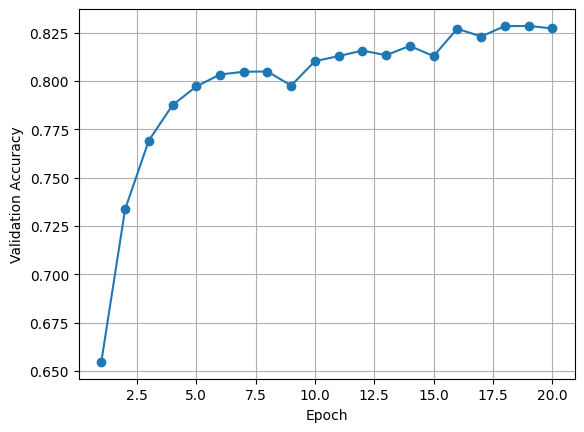

In [1023]:
epoch_num = 20
val_accuracy_list = train_func(network, train_dataloader, val_dataloader, optimizer, loss_func, epoch_num)
plt.figure()
plt.plot([i+1 for i in range(20)], val_accuracy_list, 'o-')
plt.xlabel('Epoch')  # Label for the x-axis
plt.ylabel('Validation Accuracy')  # Label for the y-axis
plt.grid(True)  # Enable grid for easier visualization of the plot lines
plt.show()

## Part 2: Enhancing Network Performance

In this section, you will focus on enhancing the performance of a neural network. Complete Tasks 2-1 and 2-2 as described below, and ensure all methods and results are well-documented in your report.

### Task 2-1: Optimize Your Neural Network

The objective of this task is to leverage the techniques learned in Part 1 to improve the validation accuracy of your neural network. You are required to explore the following aspects of neural network training and show their influences on accuracy:

1. **Network Architecture**: Experiment with different numbers and sizes of hidden layers to determine the optimal architecture.
2. **Optimizer Adjustments**: Tweak the learning rate values, including optional experiments with dynamic learning rate schedules.
3. **Training Duration**: Adjust the number of training epochs and the batch size to optimize learning.
4. **Parameter Initialization**: Experiment with various methods for initializing weights and biases to see their effects on performance.
5. **Validation Set Size**: Ensure the validation set comprises at least 20% of the total dataset, and experiment with different sizes.
6. **Additional Techniques**: You are encouraged to explore and document any other methods that could improve performance.

### Task 2-2: Evaluate Your Network's Performance

For this task, utilize the insights from Week 2 to critically evaluate your network's performance through the following methods:

1. **Accuracy Metrics**: Track and compare the prediction accuracy on both the training and validation sets throughout the training process.
2. **Loss Metrics**: Monitor and analyze the changes in loss values on the training and validation sets during training.
3. **Model Selection**: Identify, select, and save the best-performing model based on the training iterations.
4. **Confusion Matrix**: Plot and analyze the confusion matrix for the selected model to evaluate its performance across different classes.


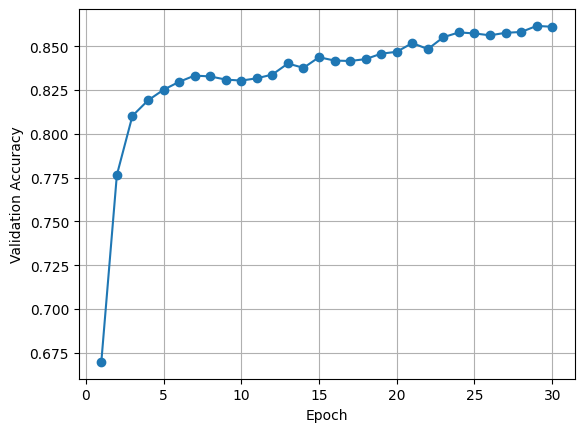

In [1024]:
# Your code: implementations for Part 2.
train_indices, val_indices = train_validate_split(mnist_data_y, val_ratio=0.2)

batch_size = 64
# Define training set dataloader object
train_dataloader = DataLoader(mnist_data_x, mnist_data_y, batch_size, train_indices)
# Define validation set dataloader object
val_dataloader = DataLoader(mnist_data_x, mnist_data_y, batch_size, val_indices)
# Define neural network
network = MLP(28*28, 128, 10)
# Define optimizer
optimizer = SGDOptimizer(network.param, lr=0.001)
# Define loss function
loss_func = SoftmaxCrossEntropy()

epoch_num = 30
val_accuracy_list = train_func(network, train_dataloader, val_dataloader, optimizer, loss_func, epoch_num)
plt.figure()
plt.plot([i+1 for i in range(epoch_num)], val_accuracy_list, 'o-')
plt.xlabel('Epoch')  # Label for the x-axis
plt.ylabel('Validation Accuracy')  # Label for the y-axis
plt.grid(True)  # Enable grid for easier visualization of the plot lines
plt.show()

## Part 3: Testing Your Optimized Network in Kaggle

### Task 3: Generate Test Predictions and Upload Them to Kaggle (Optional)

This task involves evaluating the performance of your optimized neural network using a test dataset that was not seen during the training phase. You will upload your test predictions to Kaggle to assess the model's accuracy. Follow the steps outlined below to complete this task:

1. **Kaggle Registration**: If you do not already have an account, register on [Kaggle](https://www.kaggle.com/), the leading platform for machine learning competitions.
2. **Understanding the Submission Format**: Familiarize yourself with the required submission format for Kaggle competitions by visiting the [digit recognizer competition data page](https://www.kaggle.com/competitions/digit-recognizer/data).
3. **Generating Test Predictions**:
   - Use your trained neural network to generate predictions on the provided `test.csv` file.
   - Ensure that your predictions are formatted according to the Kaggle submission guidelines.
4. **Submit Results**:
   - Upload your predictions to the [Kaggle digit recognition competition](https://www.kaggle.com/competitions/digit-recognizer/overview).
   - After submission, review the feedback on your model’s performance based on the test accuracy reported by Kaggle.

Completing this task will give you insights into how your model performs on an external, standardized dataset and allow you to benchmark your model against others in the machine learning community.


In [ ]:
# Your code: implementations for Part 3.
# Read all MNIST training data from the file
mnist_data = pd.read_csv('test.csv')
# Extract the image data from the data
mnist_data_x_test = mnist_data.iloc[:, 0:].values.astype('float')
# Extract the labels from the data
mnist_data_y_test = mnist_data.iloc[:, 0].values

(28000, 784)


In [1031]:
test_indices, _ = train_validate_split(mnist_data_y_test, val_ratio=0)

batch_size = 64
# Define training set dataloader object
test_set_dataloader = DataLoader(mnist_data_x_test, mnist_data_y_test, batch_size, test_indices)

accuracy, correct_num, total_num = validation_func(network, test_set_dataloader)
print(accuracy)

(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
